<a href="https://colab.research.google.com/github/MasahiroAraki/MLCourse/blob/master/15_reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第15章 強化学習

ここでは、強化学習アルゴリズムの勉強や開発のためのライブラリである [OpenAI Gym](https://gym.openai.com/)を使います。
Google Colabで追加設定なして実行できる[Frozen lake](https://gym.openai.com/envs/FrozenLake-v0/)問題を対象とします。

Frozen lakeは凍っている湖面上で、初期状態から出発してゴールを目指す設定です。可能な行為は上下左右の移動（'Left': 0, 'Down': 1, 'Right': 2, 'Up': 3）ですが、湖面が滑るため、確率的に意図した行為と異なる方向に移動してしまいます。ここでは、問題を簡単にするために、滑らない設定（状態遷移が決定的）から始めます。

環境は4×4のタイル状で与えられます。文字はそれぞれのタイルの定義です。

* S: 初期状態
* F: 凍っている湖面（歩行可能）
* H: 穴
* G: ゴール
* 色つきの□: プレイヤーの現在地（開始時はSと重なっている）

In [1]:
import gym
env = gym.make('FrozenLake-v0', is_slippery=False) #滑らない設定
env.render()  #現在の環境を表示


SFFF
FHFH
FFFH
HFFG


実行可能な行為数と状態数を確認します。

In [2]:
N_ACT = env.action_space.n
print("Action space: ", N_ACT)

Action space:  4


In [3]:
N_OBS = env.observation_space.n
print("Observation space: ", N_OBS)

Observation space:  16


ランダムに10step (ゴールに着いたり穴に落ちたりしたら終了)動かしてみます。このセルを何度か実行してみて、ランダムな動きではなかなかゴールに着かないことを確認してください。

In [4]:
MAX_ITERATIONS = 10

env.reset()
env.render()
for i in range(MAX_ITERATIONS):
    random_action = env.action_space.sample()  #ランダムに行為を選んで
    new_state, reward, done, info = env.step(random_action)  #現在の環境で実行
    env.render()
    if done:
        break


SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


TD法によるモデルフリー学習を試して見ます。epsilonは行為選択におけるε-greedy法のパラメータ、gammaは将来報酬の割引率、etaはTD法の学習率です。

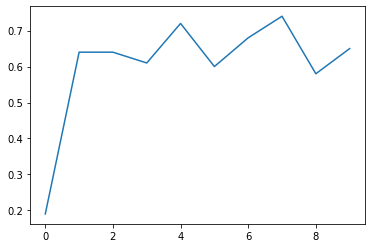

In [5]:
import numpy as np
import matplotlib.pylab as plt

q = np.zeros([N_OBS, N_ACT]) #Q値を0で初期化

#学習時のハイパーパラメータ
EPOCKS = 1000
MAX_ITERATIONS = 100
epsilon = 0.3
gamma = 0.9
eta = 0.9
 
rewards = np.zeros(EPOCKS) #各エポックでの報酬を記録するarray

for epoch in range(EPOCKS):
    obs = env.reset()
    done = False
    for step in range(MAX_ITERATIONS):
        act = np.argmax(q[obs, :]) #Q値が最大となる行為を求める
        act = np.random.choice(np.where(q[obs, :] == q[obs, act])[0]) #同じ値となるものがあれば、その中からランダムで選択
        if np.random.rand() <= epsilon: #確率epsilonでランダムに行為を選択
            act = env.action_space.sample()
        next_obs, reward, done, info = env.step(act) #行為を実行
        if not done: #最終状態（GまたはH）ではないか？
            q[obs, act] += eta * (reward - q[obs, act] + gamma * np.max(q[next_obs, :])) #TD法
        else:
            q[obs, act] += eta * (reward - q[obs, act])
        obs = next_obs
        rewards[epoch] = reward
        if done:
            break
            
rates = np.average(rewards.reshape([EPOCKS//100, 100]), axis = 1) #100エポック毎の報酬の平均値を求める
plt.plot(rates)
plt.show()

## 課題1 

報酬の平均値は学習の進行に伴って上がってはいますが、かなり不安定です。学習時のハイパーパラメータを変更して、安定的に学習ができるようにしてください。

## 課題2

下記のように滑る設定にした上で、学習時のハイパーパラメータを調整してうまく学習できるようにしてください。

env = gym.make('FrozenLake-v0') #滑る設定